In [33]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
class Value:
    def __init__(self,data , _children =() , _op = ''):
        self.data = data
        self._op = _op
        self._prev = set(_children)
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data , (self, other) , '+')
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data ,( self , other), '*')
        return out

In [35]:
from graphviz import Digraph
def trace(root):
    nodes ,edges = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges
def draw_dot(root):
    dot = Digraph(format='svg',graph_attr={'rankdir' : 'LR'})
    nodes,edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid,label = "{data %.4f}" %(n.data, ), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op ,label = n._op)
            dot.edge(uid + n._op , uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)
    return dot

In [36]:
a = Value(5)
b = Value(-5)
c = Value(6)
d = a*b + c + a*c

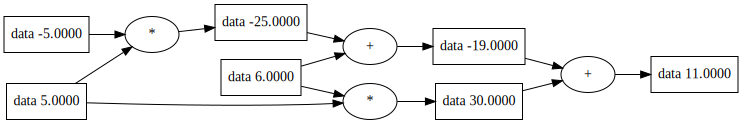

In [37]:
draw_dot(d)